# Transfer Learning with MobileNetV2

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


In [16]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


The dataset gets created as a prefetch dataset

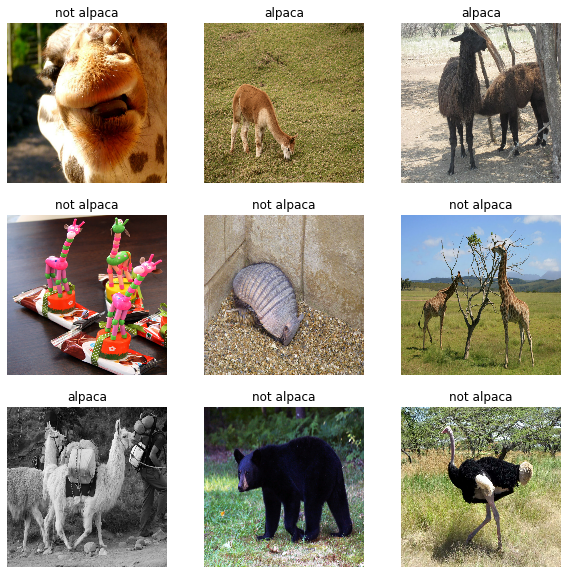

In [19]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10)) # To plot figures
for images, labels in train_dataset.take(1) : #Extracts all 32 images from the prefetch dataset as "images"
    for i in range(9): #9 images total
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) #Plot the image
        plt.title(class_names[labels[i]]) #With label
        plt.axis("off")

<a name='2'></a>
## 2 - Preprocess and Augment Training Data

You may have encountered `dataset.prefetch` in a previous TensorFlow assignment, as an important extra step in data preprocessing. 

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations. 

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.  Ahh, so convenient! 

As always, you're invited to read the official docs, which you can find for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).


In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

<a name='ex-1'></a>
### Exercise 1 - data_augmenter

Implement a function for data augmentation. Use a `Sequential` keras model composed of 2 layers:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [21]:
# UNQ_C1
# GRADED FUNCTION: data_augmenter
def data_augmenter(): #This is a dataset augmentation function
    '''
    Create a Sequential model composed of 2 layers
    which it returns
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation #Returns the sequential model that has flip and rotation

In [22]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
print('\033[92mAll tests passed!')


All tests passed!


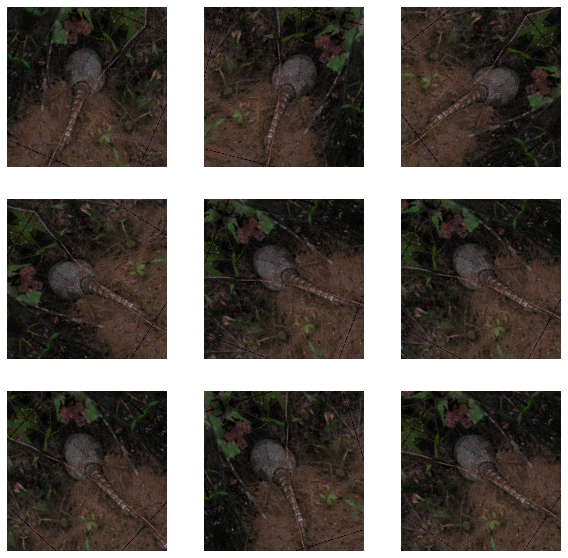

In [23]:
data_augmentation = data_augmenter() #Create an instance of your augmentation function

for image, _ in train_dataset.take(1): #Extract all images from prefetch dataset
    plt.figure(figsize=(10, 10))
    first_image = image[0] #Take just the first image
    for i in range(9): #Work on the images 5 times
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) #Pass the image through the model 9 times. 
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Next, you'll apply your first tool from the MobileNet application in TensorFlow, to normalize your input. Since you're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

<font color = 'blue'>

**What you should remember:**

* When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
* Use prefetch() to prevent memory bottlenecks when reading from disk
* Give your model more to learn from with simple data augmentations like rotation and flipping.
* When using a pretrained model, it's best to reuse the weights it was trained on.

In [24]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input #A preprocess library function that we will work with so images are ready
#For the mobilnet

Let's try to train your base model using all the layers from the pretrained model. 

Similarly to how you reused the pretrained normalization values MobileNetV2 was trained on, you'll also load the pretrained weights from ImageNet by specifying `weights='imagenet'`. 

In [44]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1): #Get all 32 images in "image"
    #plt.figure(figsize=(10, 10))
    count=np.shape(image)[0] # A counter to retrieve 32 from the shape of dataset
    for counter in range(count):
        for i in range(9): #For each image, augmentation called 9 tymes
            #ax = plt.subplot(3, 3, i + 1)
            augmented_image = data_augmentation(tf.expand_dims(image[counter], 0)) #Call the instance of function
            print(augmented_image.dtype, data_augmentation.dtype)
            #plt.imshow(augmented_image[0] / 255)
            #plt.axis('off')

<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<dtype: 'float32'> float32
<

<a name='ex-2'></a>
### Exercise 2 - alpaca_model

In [55]:
# UNQ_C2
# GRADED FUNCTION
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### the include_top =False ensures that there is no fial layer and we can use are
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    #We call the dataset and load weights. Include_top is set to False
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False #We want to freeze the model so ti doens't train

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape)  #Create an inout layer
    
    # apply data augmentation to the inputs
    x=data_augmentation(inputs) #Augment those inputs using the user defined function
    x=preprocess_input(x) #THen call the preprocess library
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)  #Pass it through base model
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) #Include average pooling and dropout
    #include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tf.keras.layers.Dense(1) #Single node as a classifier
    
    ### END CODE HERE
    
    outputs = prediction_layer(x) #Get output
    model = tf.keras.Model(inputs, outputs)
    
    return model #Return model of inputs outputs

Create your new model using the data_augmentation function defined earlier.

In [56]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [57]:
model2.summary()

Model: "functional_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_18 (Sequential)   (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)             

In [58]:
from test_utils import summary, comparator

alpaca_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                    ['Sequential', (None, 160, 160, 3), 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['Functional', (None, 5, 5, 1280), 2257984],
                    ['GlobalAveragePooling2D', (None, 1280), 0],
                    ['Dropout', (None, 1280), 0, 0.2],
                    ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation

comparator(summary(model2), alpaca_summary)

for layer in summary(model2):
    print(layer)
    

All tests passed!
['InputLayer', [(None, 160, 160, 3)], 0]
['Sequential', (None, 160, 160, 3), 0]
['TensorFlowOpLayer', [(None, 160, 160, 3)], 0]
['TensorFlowOpLayer', [(None, 160, 160, 3)], 0]
['Functional', (None, 5, 5, 1280), 2257984]
['GlobalAveragePooling2D', (None, 1280), 0]
['Dropout', (None, 1280), 0, 0.2]
['Dense', (None, 1), 1281, 'linear']


The base learning rate has been set for you, so you can go ahead and compile the new model and run it for 5 epochs:

In [59]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 9s 967ms/step - loss: 0.9798 - accuracy: 0.4122 - val_loss: 0.8808 - val_accuracy: 0.4615
Epoch 2/5
9/9 [==============================] - 7s 823ms/step - loss: 0.7407 - accuracy: 0.5802 - val_loss: 0.6177 - val_accuracy: 0.6462
Epoch 3/5
9/9 [==============================] - 7s 822ms/step - loss: 0.6725 - accuracy: 0.6489 - val_loss: 0.5277 - val_accuracy: 0.7077
Epoch 4/5
9/9 [==============================] - 7s 769ms/step - loss: 0.5500 - accuracy: 0.6718 - val_loss: 0.4810 - val_accuracy: 0.7231
Epoch 5/5
9/9 [==============================] - 7s 790ms/step - loss: 0.4572 - accuracy: 0.7443 - val_loss: 0.3897 - val_accuracy: 0.7692


Plot the training and validation accuracy:

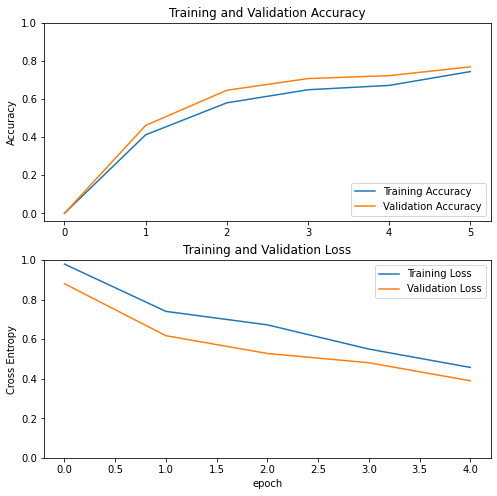

In [61]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [62]:
class_names

['alpaca', 'not alpaca']

The results are ok, but could be better. Next, try some fine-tuning.

<a name='3-3'></a>
### 3.3 - Fine-tuning the Model

You could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When you use a smaller learning rate, you take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way you achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting your learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth. 

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if your accuracy improved!

<a name='ex-3'></a>
### Exercise 3

In [63]:
# UNQ_C3
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = None
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = optimizer=tf.keras.optimizers.Adam(lr=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  155


In [64]:
assert type(loss_function) == tf.python.keras.losses.BinaryCrossentropy, "Not the correct layer"
assert loss_function.from_logits, "Use from_logits=True"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"

print('\033[92mAll tests passed!')


All tests passed!


In [65]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 9s 1s/step - loss: 0.6064 - accuracy: 0.6832 - val_loss: 0.3764 - val_accuracy: 0.7077
Epoch 6/10
9/9 [==============================] - 8s 901ms/step - loss: 0.3792 - accuracy: 0.8206 - val_loss: 0.2276 - val_accuracy: 0.8923
Epoch 7/10
9/9 [==============================] - 8s 900ms/step - loss: 0.2546 - accuracy: 0.8969 - val_loss: 0.1252 - val_accuracy: 0.9231
Epoch 8/10
9/9 [==============================] - 8s 933ms/step - loss: 0.1948 - accuracy: 0.9160 - val_loss: 0.0856 - val_accuracy: 0.9692
Epoch 9/10
9/9 [==============================] - 8s 923ms/step - loss: 0.1649 - accuracy: 0.9351 - val_loss: 0.1132 - val_accuracy: 0.9385
Epoch 10/10
9/9 [==============================] - 8s 900ms/step - loss: 0.2065 - accuracy: 0.8969 - val_loss: 0.0738 - val_accuracy: 0.9538


Ahhh, quite an improvement! A little fine-tuning can really go a long way.

In [66]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

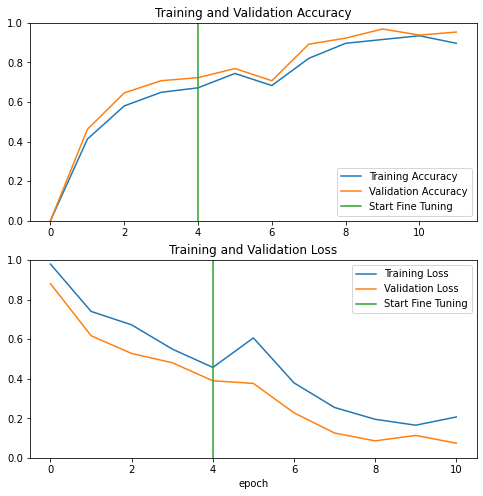

In [67]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<font color='blue'>

**What you should remember**:

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer
* When freezing layers, avoid keeping track of statistics (like in the batch normalization layer)
* Fine-tune the final layers of your model to capture high-level details near the end of the network and potentially improve accuracy 

## Congratulations!

You've completed this assignment on transfer learning and fine-tuning. Here's a quick recap of all you just accomplished:

* Created a dataset from a directory
* Augmented data with the Sequential API
* Adapted a pretrained model to new data with the Functional API and MobileNetV2
* Fine-tuned the classifier's final layers and boosted the model's accuracy

That's awesome! 